# For optimizations in the bofire domain, a GA optimizer is available
Usage is possible in multiple ways: 
1. As an alternative to the botorch optimizer in predictive strategies
2. To optimize custom function in the bofire domain. The utiliy function take care of the definition of the objective domain (variable types, constraints, etc.) and the handling of multiple experiment ($q$ points).

In [1]:
from copy import deepcopy
from time import time
from typing import List

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [3]:
from bofire.benchmarks import api as benchmarks
from bofire.data_models.constraints import api as constraints_data_models
from bofire.data_models.domain import api as domains_data_models
from bofire.data_models.features import api as features_data_models
from bofire.data_models.strategies import api as strategies_data_models
from bofire.strategies import api as strategies
from bofire.strategies.utils import run_ga

In [4]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message=".*A not p.d., added jitter")
warnings.filterwarnings("ignore", message=".*np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]")

### The GA supports multiple different constraints
Genetic algorithms are quite flexible and can handle a variety of constraints. However, they usually struggle with equality constraints. In the implementation, linear equality- and inequality constraints, as well as N-choose-k cosntraints are handled by a repair function, using QP. Nonlinear constraints are handled by the GA objective function.

## Example 1) Usage for Acquisition Function Optimization
Just pass the `GeneticAlgorithmOptimizer` to the `acquisition_optimizer` argument of a strategy. The optimizer will then be used to optimize the acquisition function.

In [5]:
benchmark = benchmarks.Himmelblau()
# generate experiments
experiments = benchmark.f(benchmark.domain.inputs.sample(10), return_complete=True)

In [6]:
optimizer = strategies_data_models.GeneticAlgorithmOptimizer(
    population_size=100,
    n_max_gen=100,
    verbose=False,
)

In [7]:
benchmark_grid = np.hstack(
    [
        x.reshape((-1, 1))
        for x in np.meshgrid(np.linspace(-6, 6, 100), np.linspace(-6, 6, 100))
    ]
)
benchmark_grid = pd.DataFrame(
    benchmark_grid, columns=benchmark.domain.inputs.get_keys()
)
benchmark_grid["y"] = benchmark.f(benchmark_grid)["y"]

In [8]:
def get_proposals(domain, n: int = 10) -> pd.DataFrame:
    strategy = strategies_data_models.SoboStrategy(
        domain=domain, acquisition_optimizer=optimizer
    )
    # map to strategy object, and train the model
    strategy = strategies.map(strategy)
    strategy.tell(experiments)
    t0 = time()
    proposals = strategy.ask(n)
    print(f"Generated {len(proposals)} experiments, Time taken: {time() - t0:.2f}s")
    return proposals

#### Linear Equality and Inequality Constraints are handled by a repair function, using QP

In [9]:
# generate different cases
domain = deepcopy(benchmark.domain)
domain.constraints.constraints += [
    constraints_data_models.LinearEqualityConstraint(  # x_1 + x_2 = 3
        features=["x_1", "x_2"],
        coefficients=[1, 1],
        rhs=3,
    ),
    constraints_data_models.LinearInequalityConstraint(  # x_2 <= x_1
        features=["x_1", "x_2"],
        coefficients=[-1, 1],
        rhs=0,
    ),
]

experiments = benchmark.f(
    strategies.RandomStrategy.make(domain=domain).ask(10), return_complete=True
)

In [10]:
proposals = get_proposals(domain)

Generated 10 experiments, Time taken: 5.31s


/var/folders/nz/mktm3tp93bb8z4cp_xyjgtzr0000gn/T/ipykernel_63806/3233680647.py:2: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(


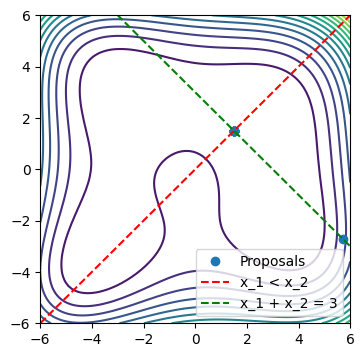

In [11]:
plt.figure(figsize=(4, 4))
plt.contour(
    benchmark_grid["x_1"].values.reshape((100, 100)),
    benchmark_grid["x_2"].values.reshape((100, 100)),
    benchmark_grid["y"].values.reshape((100, 100)),
    levels=20,
    label="true system response",
)
plt.plot(proposals["x_1"], proposals["x_2"], "o", label="Proposals")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.plot((-6, 6), (-6, 6), "r--", label="x_1 < x_2")
plt.plot((-6, 6), (9, -3), "g--", label="x_1 + x_2 = 3")
plt.legend()
plt.show()

#### NChooseK Constraints are also handled by a repair function, using QP

In [12]:
domain = deepcopy(benchmark.domain)
domain.inputs.get_by_key("x_1").bounds = (0.0, 6.0)
domain.inputs.get_by_key("x_2").bounds = (0.0, 6.0)
domain.constraints.constraints += [
    constraints_data_models.NChooseKConstraint(
        features=["x_1", "x_2"],
        min_count=1,
        max_count=1,
        none_also_valid=True,
    ),
]

experiments = benchmark.f(
    strategies.RandomStrategy.make(domain=domain).ask(10), return_complete=True
)

In [13]:
proposals = get_proposals(domain, n=10)

Generated 10 experiments, Time taken: 5.82s


/var/folders/nz/mktm3tp93bb8z4cp_xyjgtzr0000gn/T/ipykernel_63806/2764647987.py:2: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(


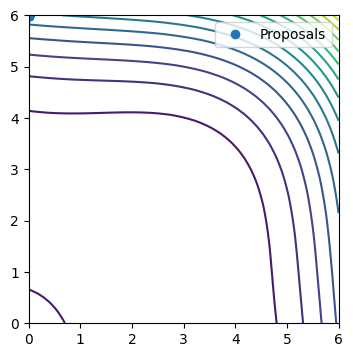

In [14]:
plt.figure(figsize=(4, 4))
plt.contour(
    benchmark_grid["x_1"].values.reshape((100, 100)),
    benchmark_grid["x_2"].values.reshape((100, 100)),
    benchmark_grid["y"].values.reshape((100, 100)),
    levels=20,
    label="true system response",
)
plt.plot(proposals["x_1"], proposals["x_2"], "o", label="Proposals")
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.legend()
plt.show()

#### Inequality Constraints are handled by the GA objctive function

In [15]:
domain = deepcopy(benchmark.domain)
domain.constraints.constraints += [
    constraints_data_models.NonlinearInequalityConstraint(
        expression="x_1**2 + x_2**2 - 16",
        features=["x_1", "x_2"],
    ),
]
proposals = get_proposals(domain, n=20)

Generated 20 experiments, Time taken: 6.13s


/var/folders/nz/mktm3tp93bb8z4cp_xyjgtzr0000gn/T/ipykernel_63806/2925682774.py:2: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(


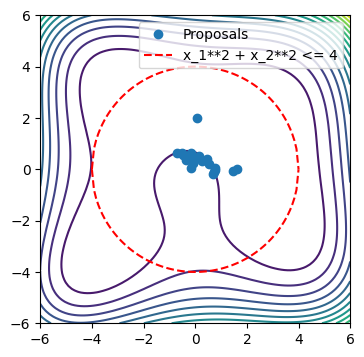

In [16]:
plt.figure(figsize=(4, 4))
plt.contour(
    benchmark_grid["x_1"].values.reshape((100, 100)),
    benchmark_grid["x_2"].values.reshape((100, 100)),
    benchmark_grid["y"].values.reshape((100, 100)),
    levels=20,
    label="true system response",
)
plt.plot(proposals["x_1"], proposals["x_2"], "o", label="Proposals")
x = np.linspace(-4, 4, 100)
y1 = np.sqrt(16 - x**2)
y2 = -y1
plt.plot(x, y1, "r--", label="x_1**2 + x_2**2 <= 4")
plt.plot(x, y2, "r--")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.legend()
plt.show()

## Example 2) Usage for Custom Function Optimization

We can define a domain with input features, and constraints. Output features are not required

In [17]:
domain = domains_data_models.Domain(
    inputs=domains_data_models.Inputs(
        features=[
            features_data_models.ContinuousInput(
                key="x_1",
                bounds=(-6, 6),
            ),
            features_data_models.ContinuousInput(
                key="x_2",
                bounds=(-6, 6),
            ),
        ]
    ),
    constraints=[
        constraints_data_models.NonlinearInequalityConstraint(
            expression="x_1**2 + x_2**2 - 16",
            features=["x_1", "x_2"],
        ),
    ],
)

In [18]:
optimizer = strategies_data_models.GeneticAlgorithmOptimizer(
    population_size=100,
    n_max_gen=100,
    verbose=False,
)

### Define the optimization problem: a) Using evaluations on `pd.DataFrame` 
We want to maximize the mean variance of the experiments dataframe. The objective function will be called with a list of dataframes, each representing a set of experiments. Each list entry is one individual in the population of the GA.
The direction of the optimizer is a minimization of the objective function. So we minimize the negative mean variance of each 3 experiments in a batch in this case.

In [19]:
def objective_function(x: List[pd.DataFrame]) -> np.ndarray:
    """assume we want to maximize the mean variance of the experiments dataframe"""
    vars = [xi.var(numeric_only=True).mean() for xi in x]
    return -np.array(vars)

Run the optimization with the utility function `run_ga`

In [20]:
x_opt, f_opt = run_ga(
    data_model=optimizer,
    domain=domain,
    objective_callables=[objective_function],  # list of objective functions to optimize
    q=3,  # number of points to optimize
    callable_format="pandas",
)

In [21]:
proposals = x_opt[0]
proposals

column,x_1,x_2
0,3.743125,1.410154
1,-3.195902,2.404179
2,-0.440330,-3.975084


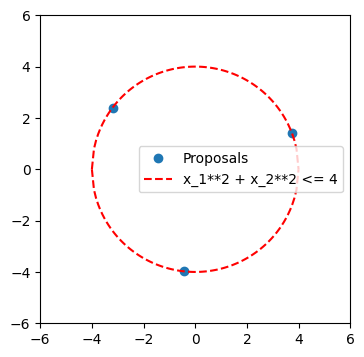

In [22]:
plt.figure(figsize=(4, 4))
plt.plot(proposals["x_1"], proposals["x_2"], "o", label="Proposals")
x = np.linspace(-4, 4, 100)
y1 = np.sqrt(16 - x**2)
y2 = -y1
plt.plot(x, y1, "r--", label="x_1**2 + x_2**2 <= 4")
plt.plot(x, y2, "r--")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.legend()
plt.show()

### Define the optimization problem: a) Using evaluations on `torch.Tensor`
For efficiency, we can also compute the objective function as a callable of type `Tensor`. In this case, the computation is in the *numerical domain*. 

This means, that categorical columns etc. are encoded. A specification with `input_preprocessing_specs` can be passed to the objective function (otherwise, defaults are used)

The objective accepts a Tensor in shape (n, q, d) and should return a Tensor of shape (n,)   

In [23]:
def objective_function(x: torch.Tensor) -> torch.Tensor:
    var = torch.var(x, dim=2)
    var_mean = torch.mean(var, dim=1)
    return var_mean

In [24]:
x_opt, f_opt = run_ga(
    data_model=optimizer,
    domain=domain,
    objective_callables=[objective_function],  # list of objective functions to optimize
    q=3,  # number of points to optimize
    callable_format="torch",
)

In [25]:
x_opt

tensor([[-1.9105, -1.9116],
        [-0.6814, -0.6821],
        [ 2.5648,  2.5660]], dtype=torch.float64)

## Example 3: Multiobjective Optimization
by giving multiple objective functions, or returning a 2D array from the objective, we will trigger multiobjective optimization

In [26]:
def objective_function_1(x: List[pd.DataFrame]) -> np.ndarray:
    """assume we want to maximize the mean variance of the experiments dataframe"""
    vars = [xi.var(numeric_only=True).mean() for xi in x]
    return -np.array(vars)

In [27]:
def objective_function_2(x: List[pd.DataFrame]) -> np.ndarray:
    """Maximize the sum of all inputs"""
    vars = [xi.sum().sum() for xi in x]
    return -np.array(vars)

In [28]:
x_opt, f_opt = run_ga(
    data_model=optimizer,
    domain=domain,
    objective_callables=[
        objective_function_1,
        objective_function_2,
    ],  # list of objective functions to optimize
    q=3,  # number of points to optimize
    callable_format="pandas",
)

In the multiobjective-case, the result is a list of `pd.DataFrame` with different pareto-optimal solutions

Text(0, 0.5, 'objective function 2')

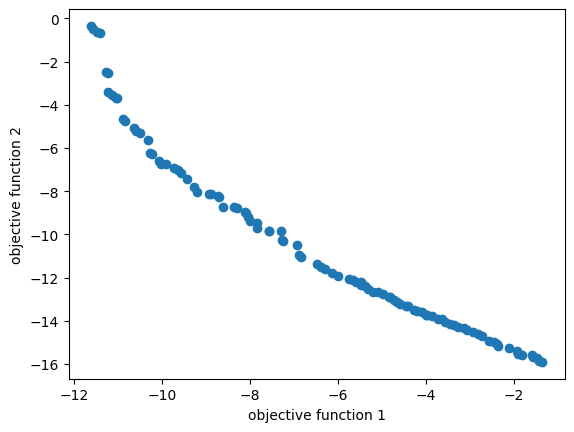

In [29]:
plt.scatter(f_opt[:, 0], f_opt[:, 1])
plt.xlabel("objective function 1")
plt.ylabel("objective function 2")

In [30]:
x_opt[0]

column,x_1,x_2
0,1.078869,3.839761
1,2.689213,2.944336
2,3.590557,1.762384


In [31]:
x_opt[1]

column,x_1,x_2
0,-3.419747,-1.737353
1,-0.462767,3.967183
2,3.638706,-1.639953
